In [65]:
# Imports
import numpy as np
import pandas as pd
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from datetime import datetime
import re


## Define tweet cleaning function

In [93]:
def preprocess_tweet(tweet):
"""Prepares tweet for scoring"""
    
    #Initalize output string
    output = ''
    
    # Remove leading 'b' if present
    if tweet[0]=='b':
        tweet = tweet[1:]
    
    # Clean each word in tweet
    for word in tweet.split():
        
        # Remove punctuation
        word = word.strip('\'"?!,.():;..')
        
        # Convert more than 2 letter repetitions to 2 letter
        #word = re.sub(r'(.)\1+', r'\1\1', word)
        
        # Remove - & '
        word = re.sub(r'(-|\')', '', word)
        
        # Remove 2 or more dots
        #word = re.sub(r'(..)', '', word)
        
        #replace consecutive non-ASCII characters with a space
        word = re.sub(r'[^\x00-\x7F]+',' ', word)
        
        # Remove twitter handles (words with leading '@')
        if len(word)==0 or word[0] == '@' :
            word = ''
       
        # Remove words containing escape character ('\')
        if '\\' in word:
            word = ''
            
        # Remove urls (words starting with 'http')
        if word[0:4] == 'http':
            word = ''
            
        # Expand acronyms
        if word == 'wtf':
            word = 'what the fuck'
        if word == 'wth':
            word = 'what the hell'
        if word == 'wtaf':
            word = 'what the actual fuck'
        if word == 'tf':
            word = 'the fuck'
        
        # Add cleaned word to output
        output += word + ' '
        
    # Remove leading spaces
    output = output.lstrip()
        
    return output


## Define tweet scoring functions

In [161]:
def compute_sentiment_score(my_tweet):
    blob = TextBlob(my_tweet)
    return blob.sentiment.polarity

def assess_sentiment(my_sentiment_score):

    # Assign sentiment bucket
    if my_sentiment_score > 0:
        sentiment = 'Positive'
    elif my_sentiment_score == 0.0:
        sentiment = 'Neutral'
    else:
        sentiment = 'Negative'
    
    return sentiment
        

## Import tweets and do basic cleaning/parsing

In [199]:
# Define candidate list
candidates = ['bennet', 'biden', 'booker', 'buttigieg', 'castro', 'delaney', 'gabbard', 'harris', 'sanders', 'warren']

# Iterate through candidate list loading data and applying parsing
data = pd.DataFrame()
for candidate in candidates:
    
    # Read in data
    file_name = f'./Resources/{candidate}.csv'
    raw_data = pd.read_csv(file_name)
    print(f'Loaded {file_name}.  {len(raw_data)} records loaded.')

    # Drop unneeded columns
    df = raw_data.drop(columns = ['User Name', 'Retweeted'])

    # Add candidate name
    df['Candidate'] = candidate

    # For Date column, convert string to normalized datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].apply(lambda x: x.normalize())
    
    # Append candidate-specific, parsed records into 'data' which holds tweets from all candidates
    data = pd.concat([data, df])

print(f'Completed loading data for all candidates.  {len(data)} total records.')

# Limit to target_date and inspect counts to verify each candidate has tweets on that date.
target_date = '2019-05-02'
data = data.loc[data['Date'] == target_date]
print(f'\nLimiting to {target_date}.  {len(data)} records remaining.\n')
      
print('Inspect counts by candidate and date to validate:')
data.groupby(['Candidate', 'Date']).count()

Loaded ./Resources/bennet.csv.  3013 records loaded.
Loaded ./Resources/biden.csv.  11999 records loaded.
Loaded ./Resources/booker.csv.  6443 records loaded.
Loaded ./Resources/buttigieg.csv.  12000 records loaded.
Loaded ./Resources/castro.csv.  1749 records loaded.
Loaded ./Resources/delaney.csv.  704 records loaded.
Loaded ./Resources/gabbard.csv.  5598 records loaded.
Loaded ./Resources/harris.csv.  12000 records loaded.
Loaded ./Resources/sanders.csv.  12000 records loaded.
Loaded ./Resources/warren.csv.  12000 records loaded.
Completed loading data for all candidates.  77506 total records.

Limiting to 2019-05-02.  29761 records remaining.

Inspect counts by candidate and date to validate:


,,Favorite Count,Retweet Count,Tweet Text
Candidate,Date,,,
bennet,2019-05-02,2066,2066,2066
biden,2019-05-02,11683,11683,11683
booker,2019-05-02,1010,1010,1010
buttigieg,2019-05-02,2302,2302,2302
castro,2019-05-02,147,147,147
delaney,2019-05-02,66,66,66
gabbard,2019-05-02,559,559,559
harris,2019-05-02,5651,5651,5651
sanders,2019-05-02,4033,4033,4033


## Compute sentiment scores

In [162]:
# Apply cleaning function to tweets
data['Cleaned Tweet Text'] = data['Tweet Text'].apply(preprocess_tweet)

# Compute score for each tweet
data['Sentiment Score'] = data['Cleaned Tweet Text'].apply(compute_sentiment_score)

# Compute sentiment bucket for each tweet
data['Sentiment Bucket'] = data['Sentiment Score'].apply(assess_sentiment)

# Save to file
data.to_csv('all_candidates.csv')

data.head()

,Date,Favorite Count,Retweet Count,Tweet Text,Candidate,Cleaned Tweet Text,Sentiment Score,Sentiment Bucket
0,2019-05-04,1,0,"b'@Chris_SactoCA Ok, but seriously wtf is Mic...",bennet,Ok but seriously what the fuck is Michael Benn...,-0.077778,Negative
1,2019-05-04,0,0,"b""@TiaBarricini Someone is shouting on Maddow'...",bennet,Someone is shouting on Maddows podcast Senator...,0.050000,Positive
2,2019-05-04,0,0,"b""@WhitcherAaron @snacks That's where the divi...",bennet,Thats where the divide comes Bennet &amp Jess...,0.000000,Neutral
3,2019-05-04,0,0,b'Here\xe2\x80\x99s what Michael wrote and pub...,bennet,what Michael wrote and published today that d...,0.000000,Neutral
4,2019-05-04,0,0,b'America stands at a crossroads. In one direc...,bennet,America stands at a crossroads In one directio...,0.400000,Positive


In [163]:
# Compute average sentiment for each candidate
average_sentiment_df = pd.DataFrame(data.groupby(['Candidate']).mean()['Sentiment Score'])
average_sentiment_df

,Sentiment Score
Candidate,
bennet,0.102954
biden,0.033066
booker,0.080718
buttigieg,0.080025
castro,0.108817
delaney,0.074509
gabbard,0.079044
harris,-0.010138
sanders,0.055870


In [176]:
# Count tweets in each sentiment bucket
snowman_counts = pd.DataFrame(data.groupby(['Candidate', 'Sentiment Bucket']).count()['Sentiment Score'])
snowman_mean = pd.DataFrame(data.groupby(['Candidate', 'Sentiment Bucket']).mean())

snowman_plot = pd.DataFrame()
snowman_plot['Count of Tweets'] = snowman_counts['Sentiment Score']
snowman_plot['Average Sentiment Score'] = snowman_mean['Sentiment Score']
snowman_plot.head()

Count of Tweets  Average Sentiment Score
Candidate Sentiment Bucket                                          
bennet    Negative                      278                -0.207417
          Neutral                      1645                 0.000000
          Positive                     1090                 0.337488
biden     Negative                     2424                -0.296374
          Neutral                      5953                 0.000000

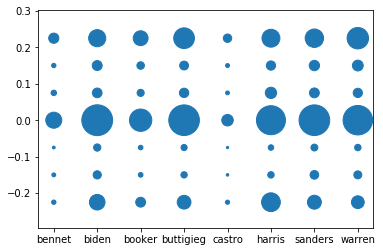

<Figure size 432x288 with 0 Axes>

In [153]:
# import matplotlib.pyplot as plt

# # Set plotting parameters
# bubble_scaling = 0.15
# candidate_count = 8

# # Create y value plotting array
# y_vals_unique = [-0.15, 0, 0.15, -0.075, 0.075, -0.225, 0.225]
# y_vals = []
# for i in range(candidate_count):
#     for y_val in y_vals_unique:
#         y_vals.append(y_val)

# # Create plot
# x = [item[0] for item in snowman_df.index.values]
# y = y_vals
# s = [bubble_scaling * val for val in snowman_df['Sentiment Score'].values]
# plt.scatter(x, y, s)
# plt.show()

# plt.savefig('snowman.png')
